### Convolve Gaussian with Exponential

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED

In [319]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[0]

In [320]:
np.random.seed(42) # for reproducibility
num_repetitions = 1
num_xs = 11763
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))
gauss_parameters = []
all_peaks = []
binary_peaks = np.zeros((num_repetitions, num_xs))

(11763,)
[np.int64(6557)]


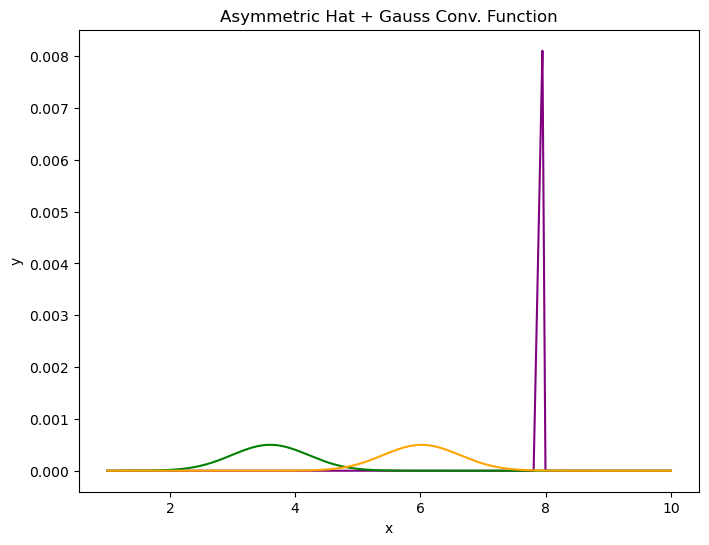

In [398]:
peaks = []

def asymmetric_hat_function(x, peak_x, peak_height, left_width, right_width):
    # Calculate the x-coordinates of the base
    left_base_x = peak_x - left_width
    right_base_x = peak_x + right_width

    # Define the conditions for each segment
    conditions = [
        (x < left_base_x),  # Before the left base
        (x >= left_base_x) & (x < peak_x),  # Rising segment
        (x >= peak_x) & (x <= right_base_x), # Falling segment
        (x > right_base_x)  # After the right base
    ]

    # Define the functions for each segment
    # (x - left_base_x) / left_width ensures the segment starts at 0 and reaches peak_height at peak_x
    # (right_base_x - x) / right_width ensures the segment starts at peak_height at peak_x and reaches 0 at right_base_x
    functions = [
        0,  # Before the left base, the value is 0
        lambda val: peak_height * (val - left_base_x) / left_width,
        lambda val: peak_height * (right_base_x - val) / right_width,
        0   # After the right base, the value is 0
    ]

    return np.piecewise(x, conditions, functions)

x_values = np.linspace(1,10,11763)
peak_x = np.random.uniform(2,9)
peak_height = np.random.uniform(0.005, 1.0)
left_width = np.random.uniform(0.01,0.3)
right_width = np.random.uniform(0.01,0.3)
hat = asymmetric_hat_function(x_values, peak_x, peak_height, left_width, right_width)
hat /= np.sum(hat)

def make_gauss(x, amp, std_dev, mean):
    gauss = np.zeros_like(x, dtype=float)
    gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    print(gauss.shape)
    return gauss

amp = np.random.uniform(0.005, 1.0)
std_dev = np.random.uniform(0.01,1.0) # rule of thumb is 7 points per peak, maybe 5
fwhm = 2 * np.sqrt(2 * np.log(2)) * std_dev
mean = np.random.uniform(2,9)

gauss = make_gauss(x_values, amp, std_dev, mean)
gauss /= np.sum(gauss)

convolved = np.convolve(hat, gauss, mode='same')

peak_index = np.argmax(convolved)
peaks.append(peak_index)

print(peaks)

# Plotting the result
plt.figure(figsize=(8, 6))
plt.plot(x_values, hat, color='purple')
plt.plot(x_values, gauss, color='green')
plt.plot(x_values, convolved, color='orange')
plt.title('Asymmetric Hat + Gauss Conv. Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [322]:
for i in range(num_repetitions):
    if peak_density == 'small':
        n_gauss = np.random.randint(5, 10)
    elif peak_density == 'medium':
        n_gauss = np.random.randint(10, 15)
    elif peak_density == 'large':
        n_gauss = np.random.randint(15, 25)
    else: n_gauss = np.random.randint(25,40)

    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []
    # new mean cannot fall into any existing FWHM ranges

    # min_d = 0.08 # shouldn't be a constant; consider the width of the peak that it's under
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:
            amp = np.random.uniform(0.005, 1.0)
            std_dev = np.random.uniform(0.02,0.1) # rule of thumb is 7 points per peak, maybe 5
            fwhm = 2 * np.sqrt(2 * np.log(2)) * std_dev

            mean = np.random.uniform(1, 8)
            min_d = fwhm * 2
            if all(abs(mean - m) >= min_d for m in used_means):
                used_means.append(mean)
                break
            attempts += 1
            if attempts > 200: # avoid inf loop
                break

        gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

        asym_gauss = np.convolve(gauss, exp)
        
        signal += asym_gauss
        parameters.append((amp, mean, std_dev))

        peak_index = np.argmax(gauss)
        peaks.append(peak_index)
        
        trim_min, trim_max = (mean - fwhm / 4, mean + fwhm / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

    signals[i] = signal
    gauss_parameters.append(parameters)
    all_peaks.append(peaks)


TypeError: unsupported operand type(s) for *: 'float' and 'function'